Microsoft AI Rangers Demo
# Deep Learning for Medical Image Analysis using the AML Platform
__Brain Tumor Classification__

<img src="images/brain-medical.png" width=600 />

__In this notebook__

- Medical imaging classification use case
- Integrate with AzureML Labeling 
- Images from managed Azure Machine Learning dataset incl. versioning
- Fine tuning of ResNet50 model with manual hyperparameter selection using PyTorch
- Tracking of selected metrics and artifacts using MLFlow
- Model Management in Azure Machine Learning
- Interpretability using PyTorch Captum

# Brain Tumor Detection Use Case
The dataset used in this demo was taken from Kaggle: https://www.kaggle.com/sartajbhuvaji/brain-tumor-classification-mri. 

The following introduction was taken from the same source:

A Brain tumor is considered one of the aggressive diseases, among children and adults. Brain tumors account for 85 to 90 percent of all primary Central Nervous System (CNS) tumors. Every year, around 11,700 people are diagnosed with a brain tumor. The 5-year survival rate for people with a cancerous brain or CNS tumor is approximately 34 percent for men and 36 percent for women. Brain Tumors are classified as: Benign Tumor, Malignant Tumor, Pituitary Tumor, etc. Proper treatment, planning, and accurate diagnostics should be implemented to improve the life expectancy of the patients. The best technique to detect brain tumors is Magnetic Resonance Imaging (MRI). A huge amount of image data is generated through the scans. These images are examined by radiologists. A manual examination can be error-prone due to the level of complexities involved in brain tumors and their properties.

Application of automated classification techniques using Machine Learning has shown higher accuracy than manual classification. Hence, proposing a system performing detection and classification by using Deep Learning Algorithms with Convolutional Neural Networks (CNN) and Transfer Learning would be helpful to doctors all around the world.

Classes in the dataset:
- Glioma tumor
- Meningioma tumor
- Pituitary tumor
- No tumor

__Acknowledgements for Dataset: Navoneel Chakrabarty, Swati Kanchan__

# Setup

## Installs and Imports

In [1]:
# !pip install torchinfo captum split-folders

In [1]:
import logging
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import mlflow
import azureml.core
from azureml.core import Workspace, Dataset, Experiment, Run, Model

import torch
import torch.nn.functional as F
from torch.utils.data.dataloader import DataLoader
import torchvision.transforms as T
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torchinfo import summary
from torchvision.utils import make_grid

import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.colors import LinearSegmentedColormap
from PIL import Image

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

import captum
from captum.attr import LayerGradCam, LayerAttribution
from captum.attr import visualization as viz

import shutil
import json
import splitfolders
from textwrap import wrap
from datetime import datetime
from utils.demoutils import train, plot_learning_curve, to_categorical, predict_loader, inverse_normalize, plot_confusion_matrix

## Connect to Azure ML workspace and MLflow
Connect to AzureML Workspace and link to MLflow tracking. Also define `record()` function to log relevant information to console output or Run History using MLflow.

In [2]:
logging.basicConfig(filename='experiment.log', filemode = 'w', format='%(levelname)s: %(message)s')
logger=logging.getLogger()
logger.setLevel(logging.INFO)

def record(entry, console=True, logfile=True):
    ''' log entry to console and/or logfile file '''
    logentry = f'{datetime.now().strftime("%d/%m/%Y %H:%M")} : {entry}' 
    if console:
        print(logentry)
    if logfile:
        logger.info(logentry)

In [3]:
ws = Workspace.from_config()
mlflow.set_tracking_uri(ws.get_mlflow_tracking_uri())

record(f'Ready to use Azure ML {azureml.core.VERSION} and MLflow {mlflow.__version__} with Workspace {ws.name}')

23/01/2022 11:07 : Ready to use Azure ML 1.36.0 and MLflow 1.21.0 with Workspace harmke-andreas-demo


## Set parameters and initialize experiment

In [4]:
# Global settings and  hyperparameters
random_seed = 1
experiment_name = 'brain-tumor-classification'
base_dir = '/home/azureuser/brain-tumor'
base_dir_tvt = '/home/azureuser/brain-tumor-tvt'
model_path = './outputs/brain-tumor-classification.pth'

train_val_test_split = (0.8, 0.1, 0.1)
img_height, img_width, channels = 256, 256, 3
rgb_means = (0.1781, 0.1781, 0.1781)
rgb_stds = (0.1936, 0.1936, 0.1936) 
batch_size = 32
learning_rate = 5.0e-5
epochs = 15

device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
if device.type == 'cuda':
    record(f'{torch.cuda.device_count()} instance(s) of {torch.cuda.get_device_name(0)} GPU available')

23/01/2022 11:07 : 2 instance(s) of Tesla V100-PCIE-16GB GPU available


In [5]:
# Submit experiment run
experiment = Experiment(ws, experiment_name)
mlflow.set_experiment(experiment.name)

# make MLFlow run accessible for AML SDK
mlflow.start_run()
run_id = mlflow.active_run().info.run_id
amlrun = Run(experiment, run_id)

record(f'Experiment run with id {run_id} started.')

23/01/2022 11:07 : Experiment run with id c393838c-24d8-4caa-9bc6-b5de61fd120e started.


# Acquire and prepare image data
## Upload local to AzureML and create dataset

When you use this notebook for the first time, the brain tumor image dataset will be uploaded to the default AzureML datastore and registered as a managed file dataset. 
Please download the original data from the following location: https://www.kaggle.com/sartajbhuvaji/brain-tumor-classification-mri.

Copy all train and test images into one consolidated folder structure with the label names as subfolders. We will split the daaset into training, validation and test partitions later.

Folder __brain-tumor_all__ with subfolders: 
- glioma_tumor
- meningioma-tumor
- no-tumor
- pituitary-tumor

Zip the __brain_tumor_all__ folder, copy the zip archive it to a local folder (e.g., ./datasets).

Finally, execute the following two cells to upload the data and to register a managed file dataset.

__This needs to be done only once. When the dataset is registered with AzureML it can be reused in later experiments.__




In [ ]:
import os
import urllib
from zipfile import ZipFile

data_file = './datasets/brain-tumor-complete.zip'
data_folder = './datasets'

# extract files
with ZipFile(data_file, 'r') as zip:
    print('extracting files...')
    zip.extractall(data_folder)
    print('done')
    
# delete zip file
# os.remove(data_file)

In [ ]:
from azureml.core import Workspace, Datastore, Dataset
from azureml.data.datapath import DataPath

# Upload data to AzureML Datastore
ds = ws.get_default_datastore()
ds = Dataset.File.upload_directory(src_dir='./datasets/brain-tumor-all',
           target=DataPath(ds, 'brain-tumor-complete'),
           show_progress=False, overwrite=True)

# Register file dataset with AzureML
ds = ds.register(workspace=ws, name='brain-tumor-complete', description='MRI images for brain tumor classification')

record(f'Dataset {ds.name} registered.')

## Select managed dataset from AML Workspace 
__Continue here if the dataset is already registered with AzureML__ 

In [6]:
aml_dataset = Dataset.get_by_name(ws, name='brain-tumor-complete', version='latest')

shutil.rmtree(base_dir) # delete files from previous experiment with potentially different dataset
filelist = aml_dataset.download(target_path=base_dir, overwrite=True)
splitfolders.ratio(base_dir, base_dir_tvt, random_seed, ratio=train_val_test_split)

record(f'{len(filelist)} files downloaded to {base_dir_tvt}')

Copying files: 3160 files [00:00, 3598.52 files/s]


23/01/2022 11:08 : 3160 files downloaded to /home/azureuser/brain-tumor-tvt


## Preprocess and prepare PyTorch dataloaders
Perform basic data augmentation for a more robust model and record settings in experiment.

In [7]:
transform_train = T.Compose([T.Resize((img_height+20, img_width+20)), 
                             T.RandomRotation(degrees = 7),
                             T.CenterCrop((img_height, img_width)),
                             T.RandomHorizontalFlip(p = 0.5),
                             T.ToTensor(),
                             T.Normalize(rgb_means, rgb_stds)    
                            ])

transform_val = T.Compose([T.Resize((img_height, img_width)),
                           T.ToTensor(),   
                           T.Normalize(rgb_means, rgb_stds)    
                          ])

train_ds = ImageFolder(os.path.join(base_dir_tvt, 'train'), transform_train)
val_ds = ImageFolder(os.path.join(base_dir_tvt, 'val'), transform_val)
test_ds = ImageFolder(os.path.join(base_dir_tvt, 'test'), transform_val)

train_ldr = DataLoader(train_ds, batch_size, shuffle = True)
val_ldr = DataLoader(val_ds, batch_size)
test_ldr = DataLoader(test_ds, batch_size)

img_transforms = ' '.join(map(str, train_ds.transform.__dict__['transforms']))

record(f'Image transformations: {img_transforms}')
record(f'Dataset classes: {train_ds.classes} with {len(train_ds)} training, {len(val_ds)} val. and {len(test_ds)} test images.')

23/01/2022 11:08 : Image transformations: Resize(size=(276, 276), interpolation=bilinear) RandomRotation(degrees=[-7.0, 7.0], interpolation=nearest, expand=False, fill=0) CenterCrop(size=(256, 256)) RandomHorizontalFlip(p=0.5) ToTensor() Normalize(mean=(0.1781, 0.1781, 0.1781), std=(0.1936, 0.1936, 0.1936))
23/01/2022 11:08 : Dataset classes: ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor'] with 2525 training, 314 val. and 321 test images.


## Review examples of preprocessed images
Ensure that data augmentation did not introduce artifacts that might impact training performance. Image transformations will be logged in run history.

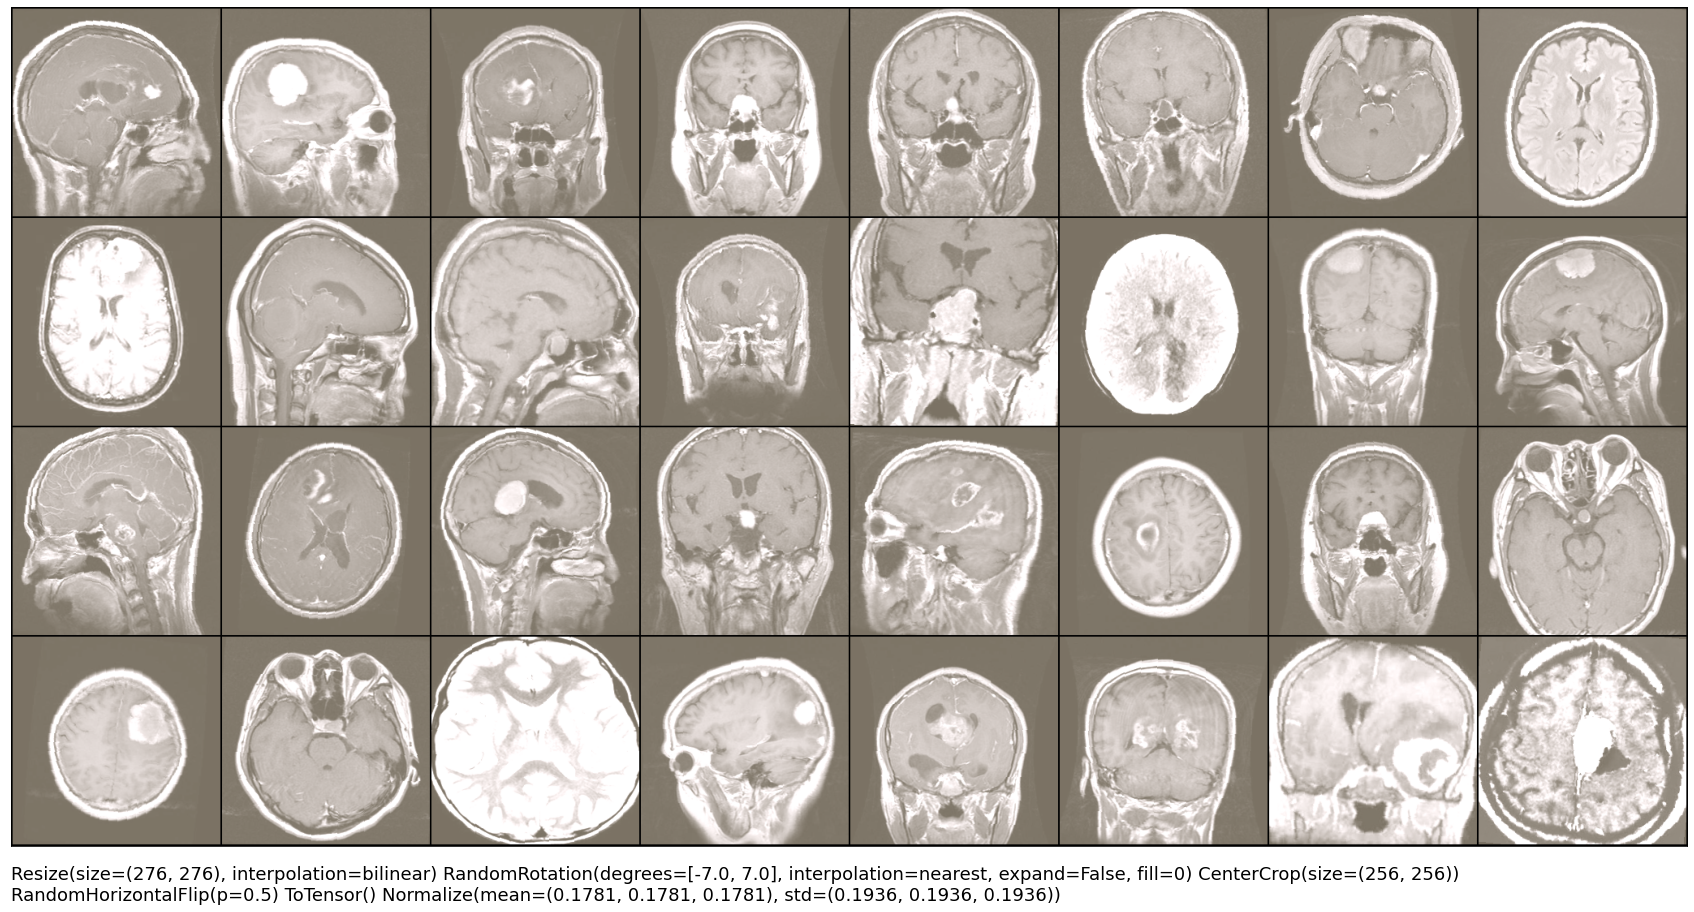

In [8]:
images, labels = next(iter(train_ldr))
fig, ax = plt.subplots(figsize=(24, 12))
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(make_grid(inverse_normalize(images), nrow = 8).permute(1, 2, 0))
plt.tight_layout()

plt.annotate('\n'.join(wrap(img_transforms,160)), (0,0), (0, -20), xycoords='axes fraction', textcoords='offset points', va='top', fontsize=18)

# record images to run history
preprocessed_samples = plt.gcf()
try:
    mlflow.log_figure(preprocessed_samples, 'sample-images.png')
except Exception as e: print(e)

plt.show()

# Use pretrained ResNet50 model

In [9]:
def get_resnet50():
    model = models.resnet50(pretrained=True)
    # Adjust last layer to 4 target classes
    num_ftrs = model.fc.in_features
    model.fc = torch.nn.Linear(num_ftrs, len(train_ds.classes))
    return model

model = get_resnet50().to(device)

In [10]:
model_summary = summary(model, input_size=(1,channels, img_height, img_width))
print(str(model_summary))

try: mlflow.log_text(str(model_summary), 'model-summary.txt')
except Exception as e: print(e)

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   --                        --
├─Conv2d: 1-1                            [1, 64, 128, 128]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 128, 128]         128
├─ReLU: 1-3                              [1, 64, 128, 128]         --
├─MaxPool2d: 1-4                         [1, 64, 64, 64]           --
├─Sequential: 1-5                        [1, 256, 64, 64]          --
│    └─Bottleneck: 2-1                   [1, 256, 64, 64]          --
│    │    └─Conv2d: 3-1                  [1, 64, 64, 64]           4,096
│    │    └─BatchNorm2d: 3-2             [1, 64, 64, 64]           128
│    │    └─ReLU: 3-3                    [1, 64, 64, 64]           --
│    │    └─Conv2d: 3-4                  [1, 64, 64, 64]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 64, 64]           128
│    │    └─ReLU: 3-6                    [1, 64, 64, 64]           --
│ 

In [11]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

mlflow.log_params({'Architecture' : 'ResNet50',
                   'Transfer Learning' : 'Yes',
                   'Epochs' : epochs,
                   'Optim' : str(optimizer).split()[0],
                   'LR' : learning_rate,
                   'Batch size' : train_ldr.batch_size,
                   'Train size' : len(train_ds),
                   'Preprocess' : img_transforms[:255]})

In [12]:
torch.manual_seed(random_seed)
total_time_sec, time_per_epoch_sec, best_model, history = train(model = model,
                             device=device,
                             optimizer = optimizer,
                             loss_fn = torch.nn.CrossEntropyLoss(),
                             train_dl = train_ldr,
                             val_dl = val_ldr,
                             epochs = epochs)

record('Training finished after {:.1f} min ({:.1f} sec per epoch) with best validation accuracy of {:.4f}'
.format(total_time_sec/60, time_per_epoch_sec, max(history['val_acc'])))

train() called: model=ResNet, opt=Adam(lr=0.000050), epochs=15, device=cuda

Epoch   1/ 15, train loss:  0.57, train acc:  0.79, val loss:  0.27, val acc:  0.90 <- best epoch so far
Epoch   2/ 15, train loss:  0.17, train acc:  0.94, val loss:  0.17, val acc:  0.94 <- best epoch so far
Epoch   3/ 15, train loss:  0.09, train acc:  0.98, val loss:  0.13, val acc:  0.95 <- best epoch so far
Epoch   4/ 15, train loss:  0.06, train acc:  0.98, val loss:  0.12, val acc:  0.96 <- best epoch so far
Epoch   5/ 15, train loss:  0.08, train acc:  0.98, val loss:  0.10, val acc:  0.97 <- best epoch so far
Epoch   6/ 15, train loss:  0.04, train acc:  0.99, val loss:  0.10, val acc:  0.96 
Epoch   7/ 15, train loss:  0.03, train acc:  0.99, val loss:  0.12, val acc:  0.96 
Epoch   8/ 15, train loss:  0.03, train acc:  0.99, val loss:  0.07, val acc:  0.97 
Epoch   9/ 15, train loss:  0.03, train acc:  0.99, val loss:  0.13, val acc:  0.96 
Epoch  10/ 15, train loss:  0.03, train acc:  0.99, val lo

# Review training progress

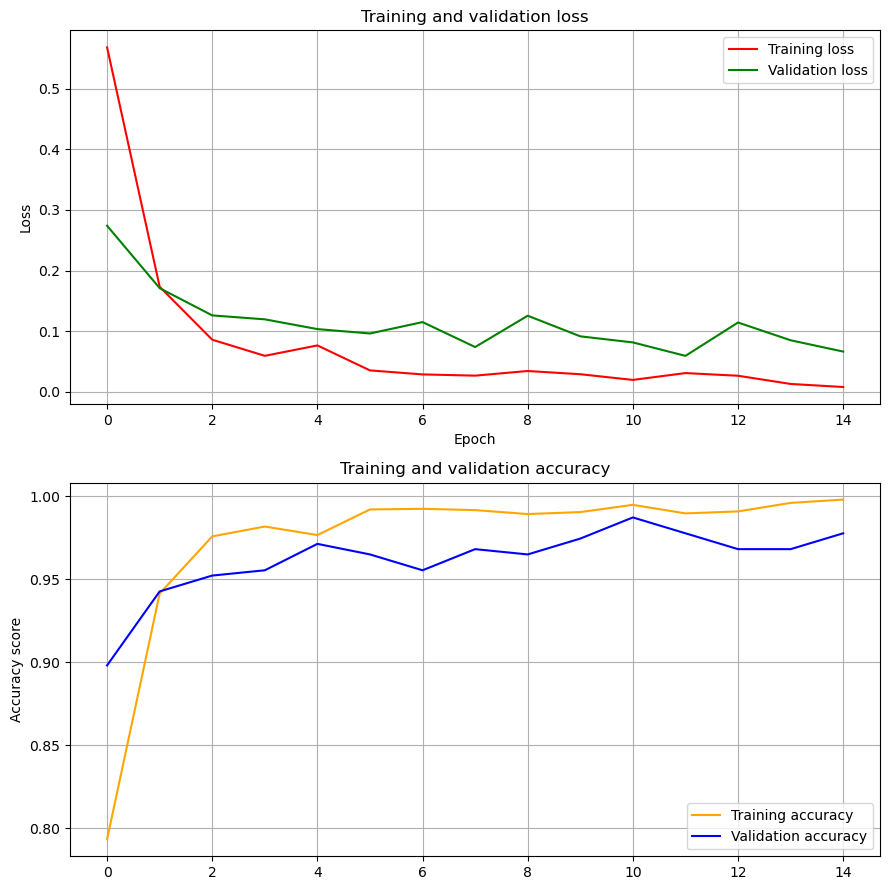

In [13]:
fig = plot_learning_curve(history)
try:
    mlflow.log_figure(fig, 'learning-curves.png')
except Exception as e: print(e)
plt.show()

# Evaluate and explain model

## Generate test set predictions and classification report

In [14]:
y_true, y_pred, y_probs = predict_loader(model, test_ldr, device)

y_true = y_true.cpu()
y_pred = y_pred.cpu()
y_probs = y_probs.cpu()

y_true_oh = to_categorical(y_true, num_classes = len(train_ds.classes))
y_pred_oh = to_categorical(y_pred, num_classes = len(train_ds.classes))

accuracy_sc = accuracy_score(y_true, y_pred)
roc_auc_sc = roc_auc_score(y_true_oh, y_probs)

print(classification_report(y_true, y_pred, target_names = train_ds.classes))
try:
    mlflow.log_metrics({'Test Accuracy' : accuracy_sc, 'Test AUC' : roc_auc_sc})
except Exception as e: print(e)
record(f'Model evaluated on test set with accuracy of {accuracy_sc:.4f} and AUC score of {roc_auc_sc:.4f}')

                  precision    recall  f1-score   support

    glioma_tumor       0.93      0.97      0.95        94
meningioma_tumor       0.95      0.94      0.94        95
        no_tumor       1.00      0.95      0.97        41
 pituitary_tumor       1.00      0.99      0.99        91

        accuracy                           0.96       321
       macro avg       0.97      0.96      0.96       321
    weighted avg       0.96      0.96      0.96       321

23/01/2022 11:17 : Model evaluated on test set with accuracy of 0.9626 and AUC score of 0.9986


## Create confusion matrix and log with experiment

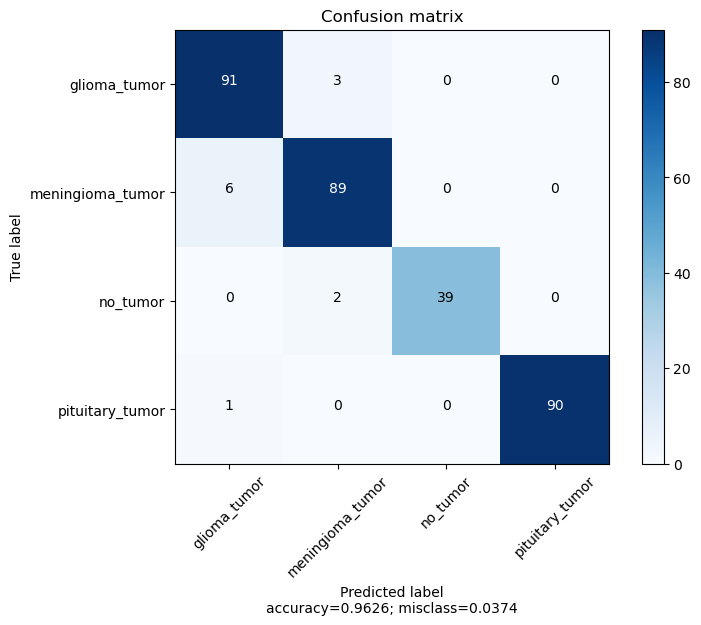

In [15]:
conf = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(conf, train_ds.classes, normalize=False)

# Define confusion matrix metadata as dict
cm_info = {"schema_type" : "confusion_matrix",
           "schema_version" : "1.0.0",
           "data" : {}}

# Add confusion_matrix from scikit-learn to dict
cm_info['data']['class_labels'] = test_ds.classes
cm_info['data']['matrix'] = conf.tolist()
json_cm_info = json.dumps(cm_info)

# log to current run in AML
try:
    amlrun.log_confusion_matrix('Test set confusion matrix', cm_info)
except Exception as e: print(e)

## Save model of best epoch

In [16]:
torch.save(best_model.state_dict(), model_path)

## Explain predictions with Grad-CAM

__Gradient-weighted Class Activation Mapping__ (Grad-CAM), uses the gradients of any target concept, flowing into the final convolutional layer to produce a coarse localization map highlighting important regions in the image for predicting the output. Grad-CAM is applicable to a wide variety of CNN model-families: (1) CNNs with fully-connected layers, (2) CNNs used for structured outputs, (3) CNNs used in tasks with multimodal inputs or reinforcement learning, without any architectural changes or re-training.



In [17]:
# retrieve saved model that we want to explain
model = get_resnet50()
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

### Preprocess image for explanations

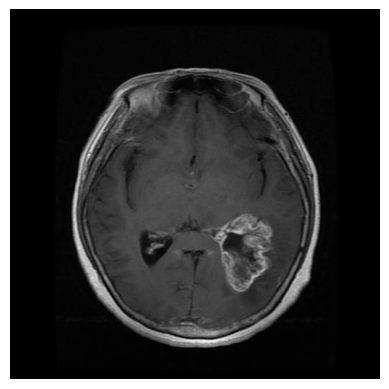

Predicted: glioma_tumor (0.9993)


In [18]:
model = model.to('cpu')
model.eval()
idx_to_labels = {idx : name for idx, name in enumerate(train_ds.classes)}

# Get test image for explanations
test_img = Image.open('./explain-samples/glioma-1.jpg')
test_img_data = np.asarray(test_img)
plt.imshow(test_img_data)
plt.axis('off')
plt.show()

# Preprocess for inference and explanations
transform = T.Compose([T.Resize((img_height, img_width)), T.ToTensor()])
transform_normalize = T.Normalize(rgb_means, rgb_stds)

transformed_img = transform(test_img)
input_img = transform_normalize(transformed_img)
input_img = input_img.unsqueeze(0) 

def predict(input_img):
    output = model(input_img)
    output = F.softmax(output, dim=1)
    prediction_score, pred_label_idx = torch.topk(output, 1)
    pred_label_idx.squeeze_()
    predicted_label = idx_to_labels[pred_label_idx.item()]
    print('Predicted: {} ({:.4f})'.format(predicted_label, prediction_score.squeeze().item()))
    return pred_label_idx, predicted_label

pred_label_idx, predicted_label = predict(input_img)

### Get explanations for test image

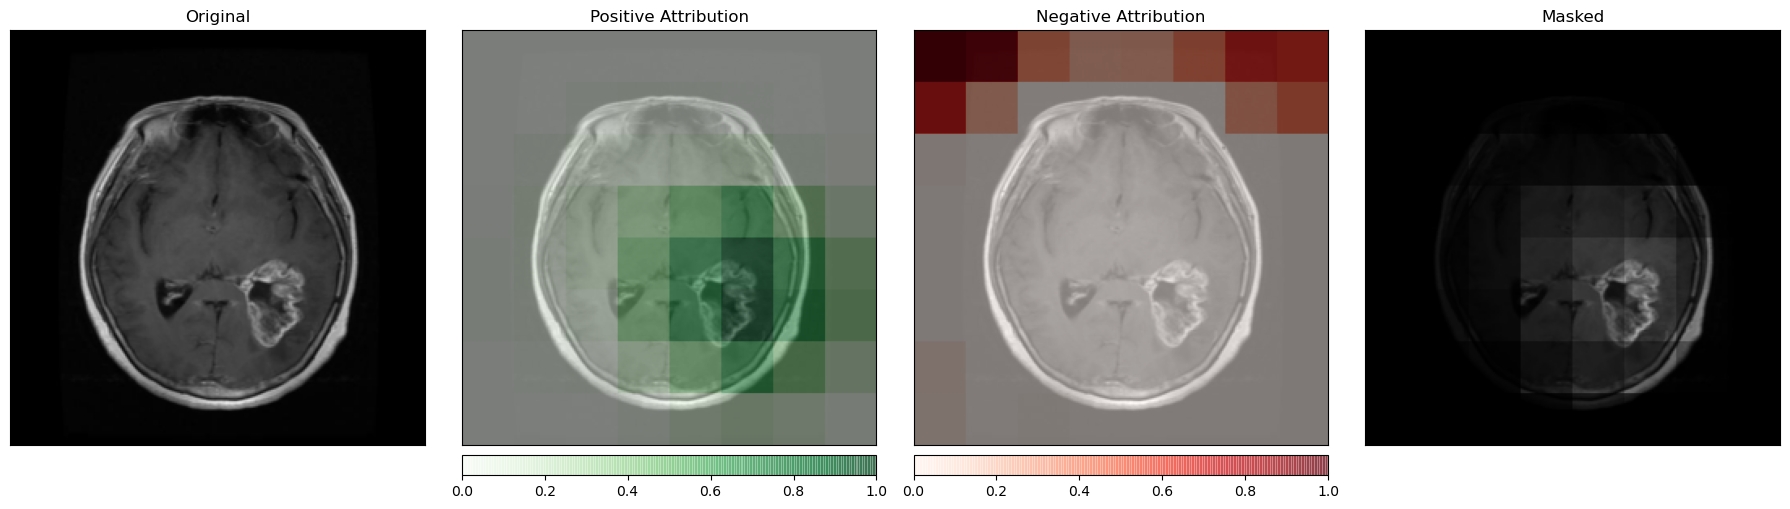

In [19]:
layer_gradcam = LayerGradCam(model, model.layer4[2].conv2)
attributions_lgc = layer_gradcam.attribute(input_img, target=pred_label_idx)
upsamp_attr_lgc = LayerAttribution.interpolate(attributions_lgc, input_img.shape[2:])

fig = viz.visualize_image_attr_multiple(upsamp_attr_lgc[0].cpu().permute(1,2,0).detach().numpy(),
                                      transformed_img.permute(1,2,0).numpy(),
                                      ["original_image", "blended_heat_map", "blended_heat_map", "masked_image"],
                                      ["all","positive","negative", "positive"],
                                      show_colorbar=True,
                                      titles=["Original", "Positive Attribution", "Negative Attribution", "Masked"],
                                      fig_size=(18, 6))

try:
    mlflow.log_figure(fig[0], 'GradCAM-explanations.png')
except Exception as e: print(e)

### Get explanations for samples of all classes

Predicted: glioma_tumor (0.9993)


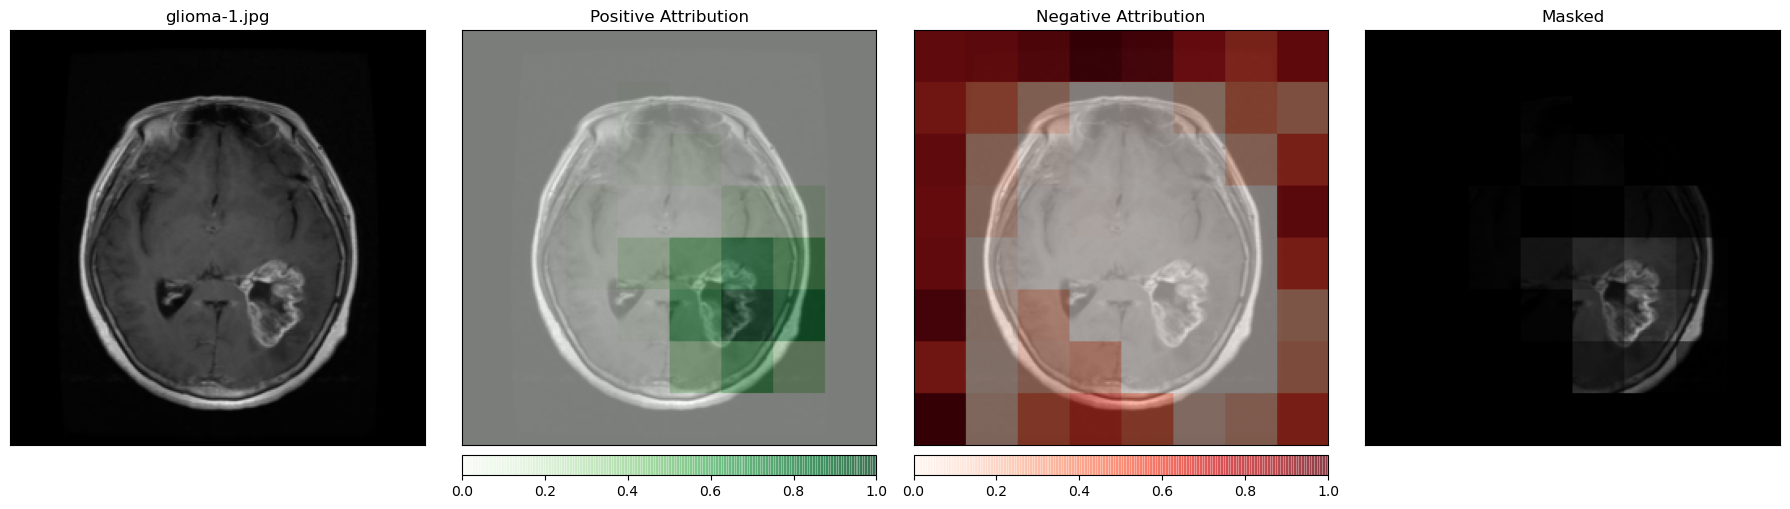

Predicted: glioma_tumor (1.0000)


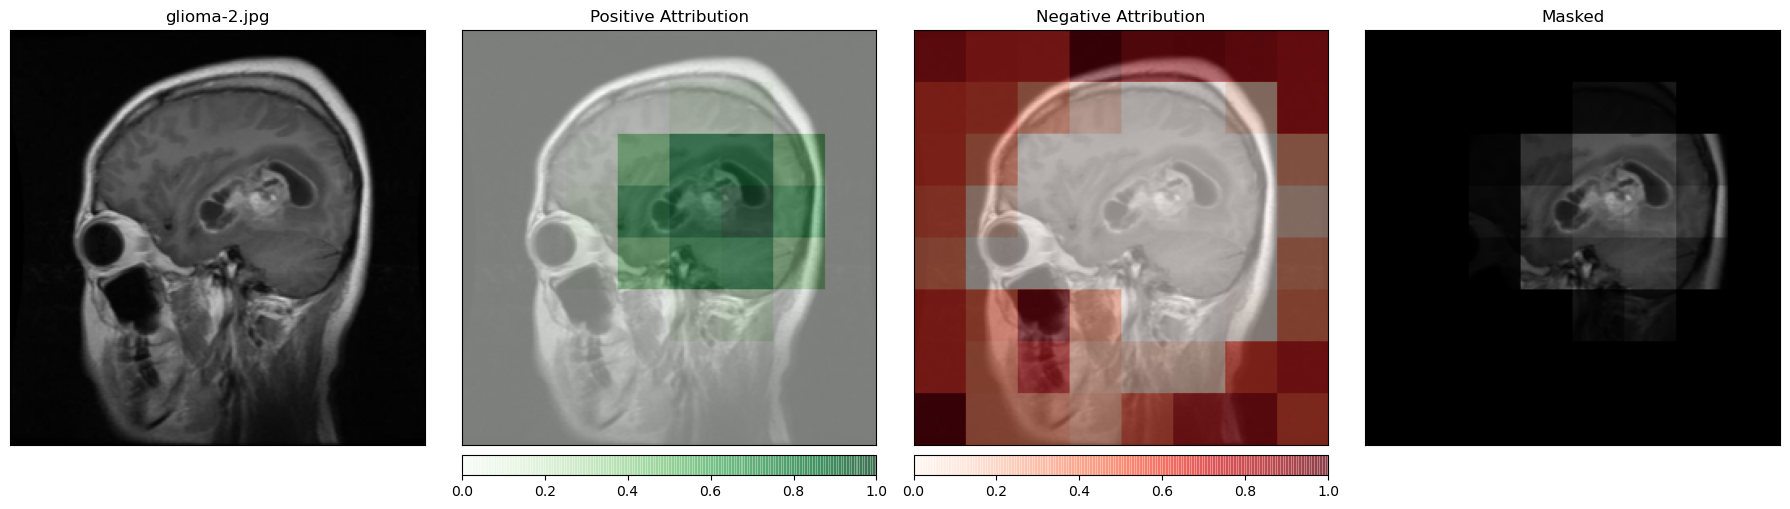

Predicted: glioma_tumor (0.9999)


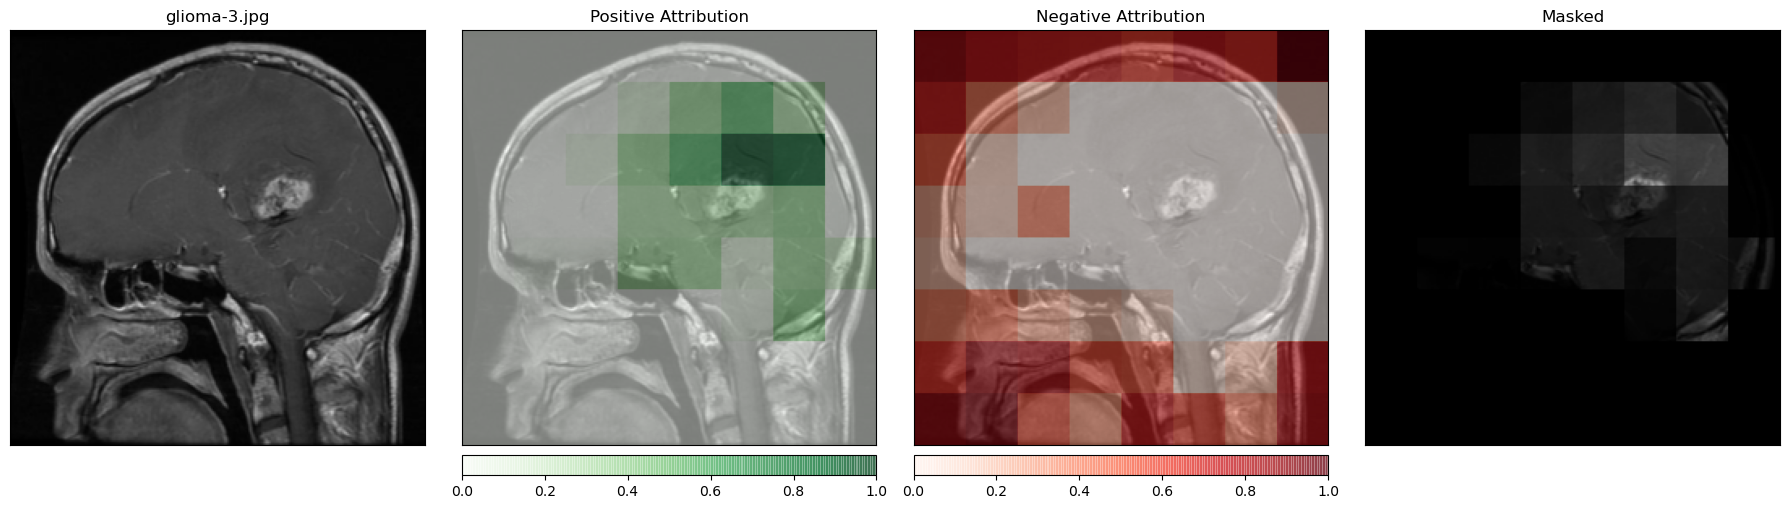

Predicted: meningioma_tumor (0.9876)


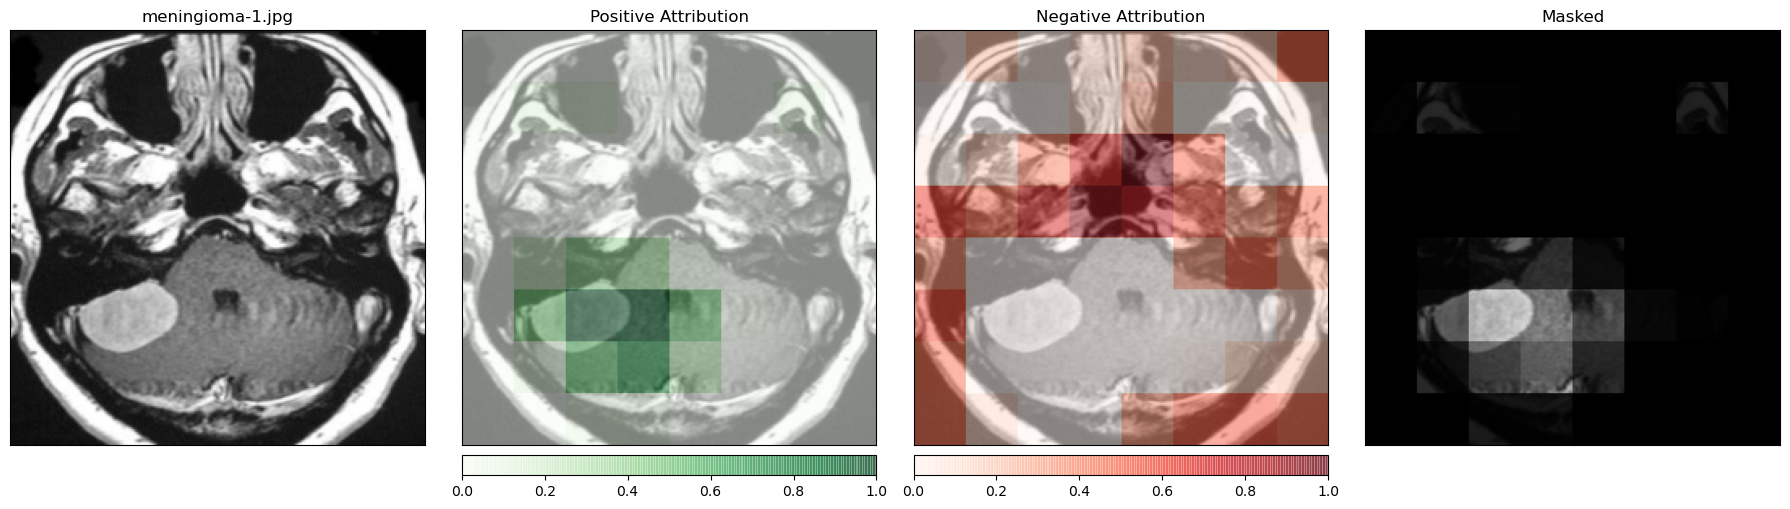

Predicted: meningioma_tumor (0.9992)


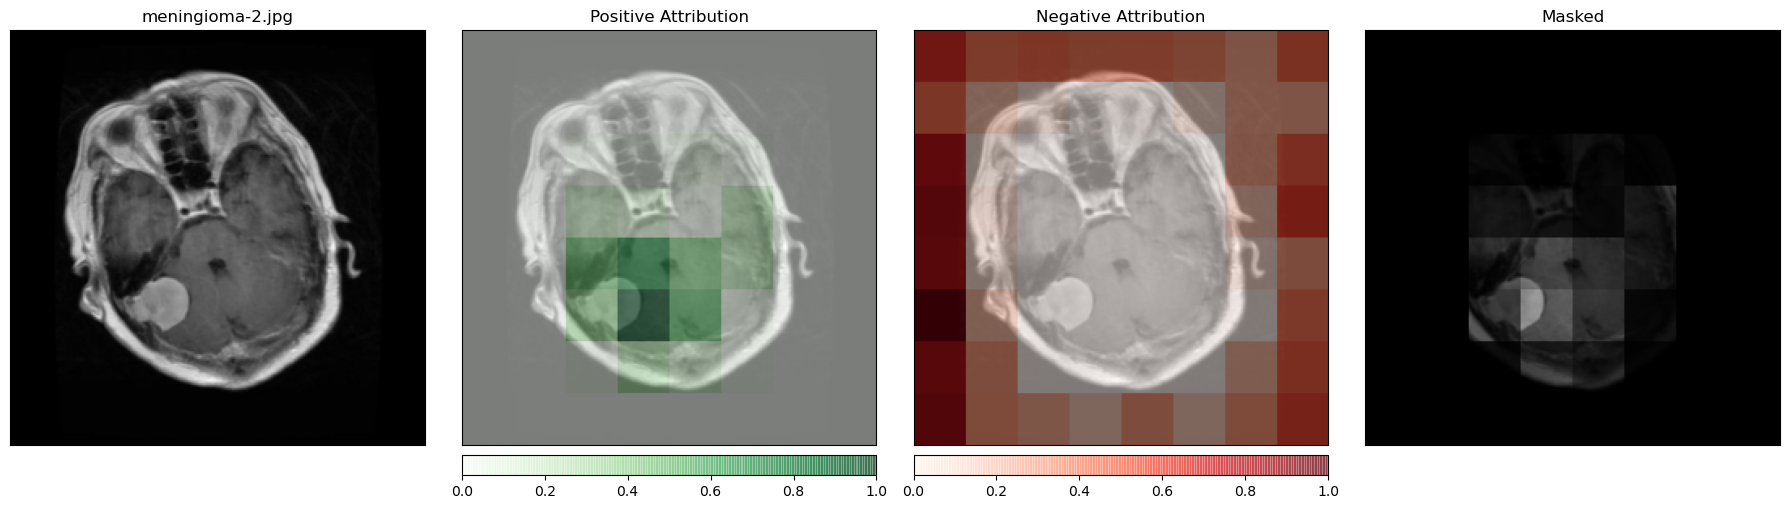

Predicted: meningioma_tumor (0.9982)


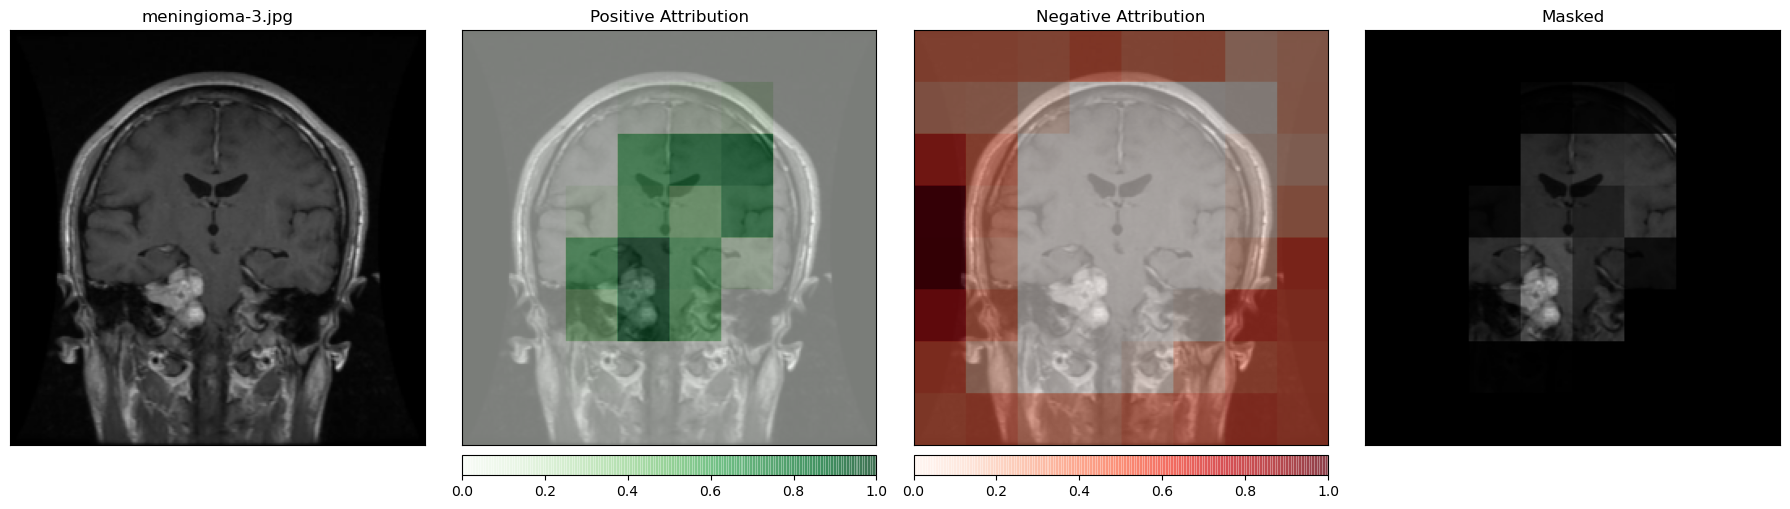

Predicted: no_tumor (0.9803)


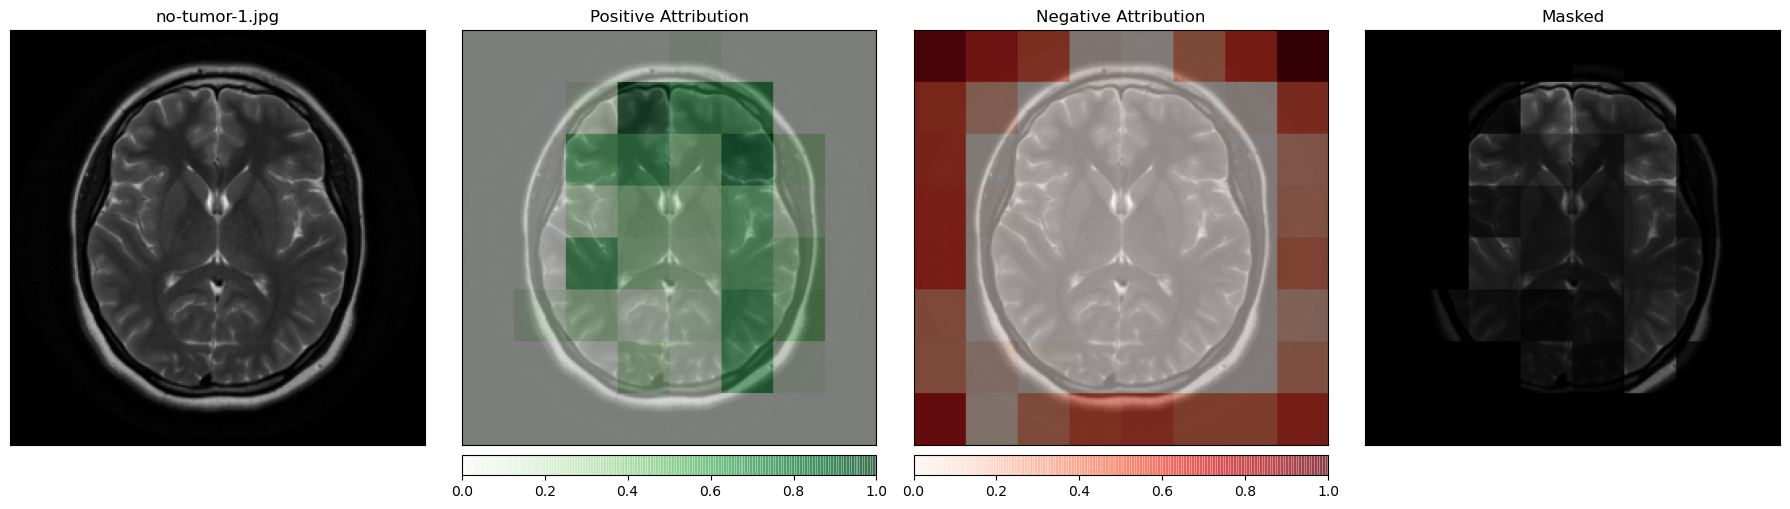

Predicted: no_tumor (0.9977)


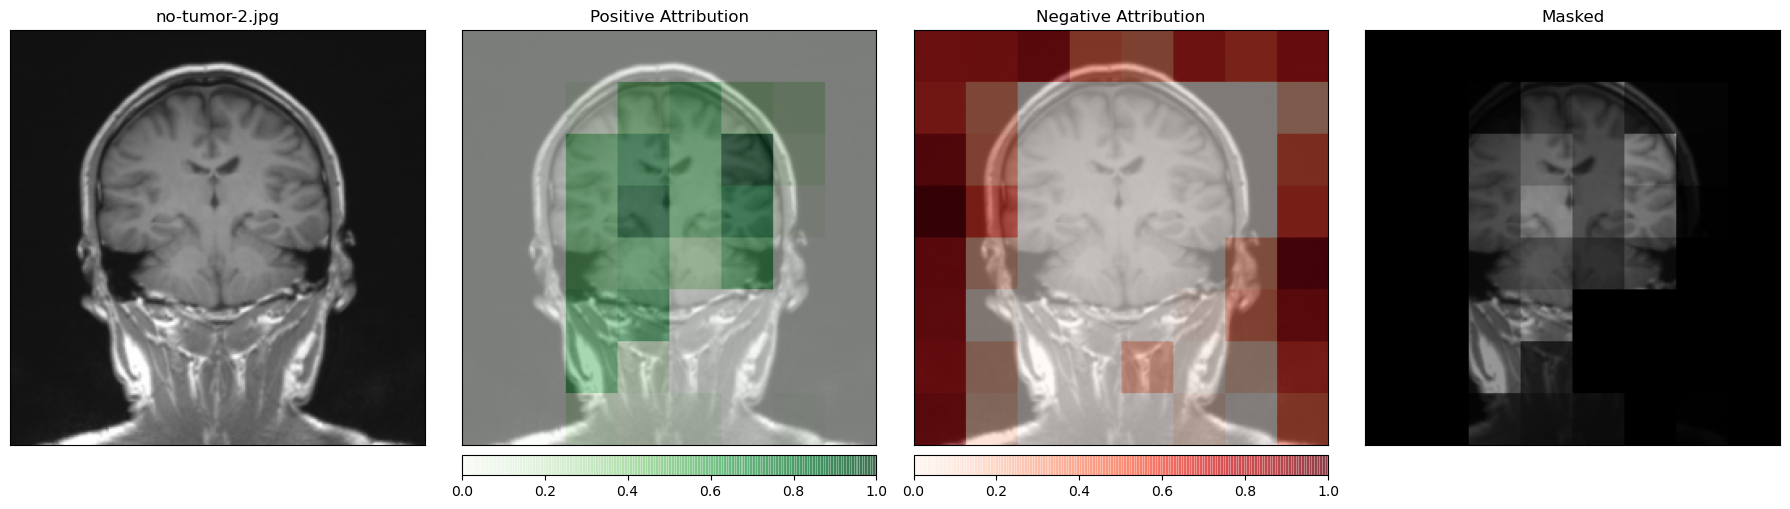

Predicted: no_tumor (0.9996)


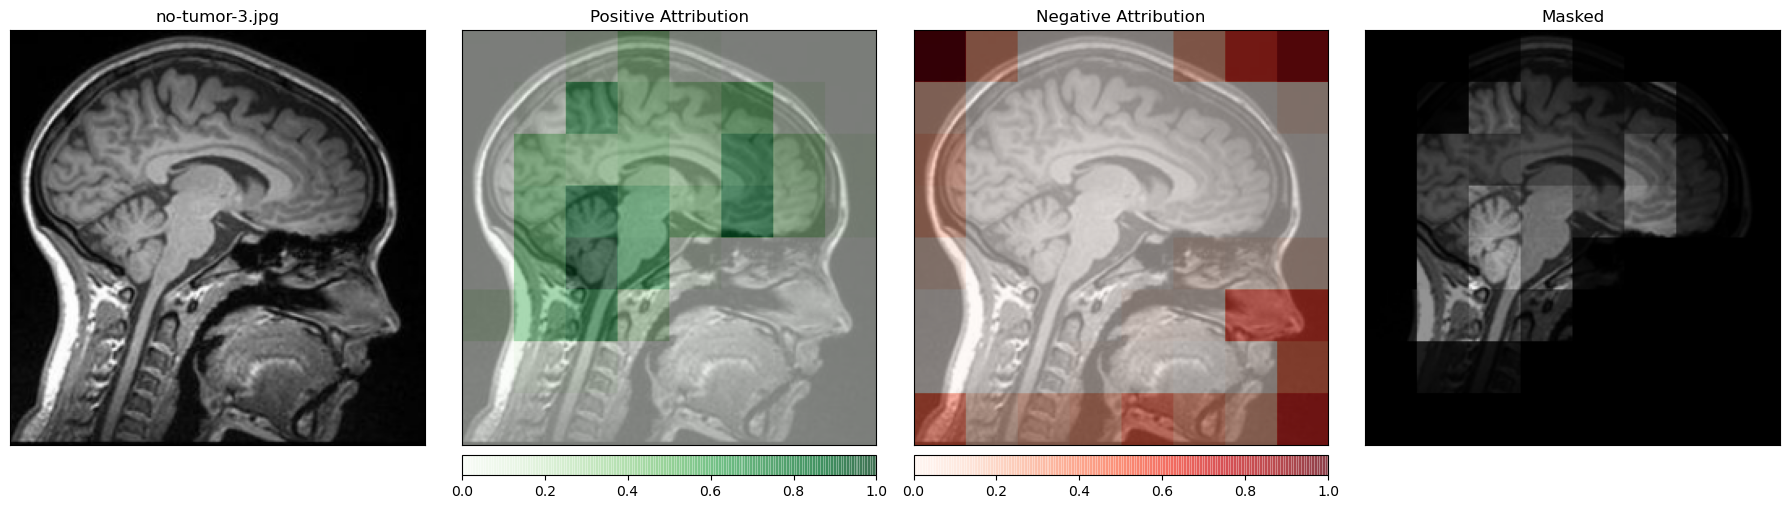

Predicted: pituitary_tumor (0.9983)


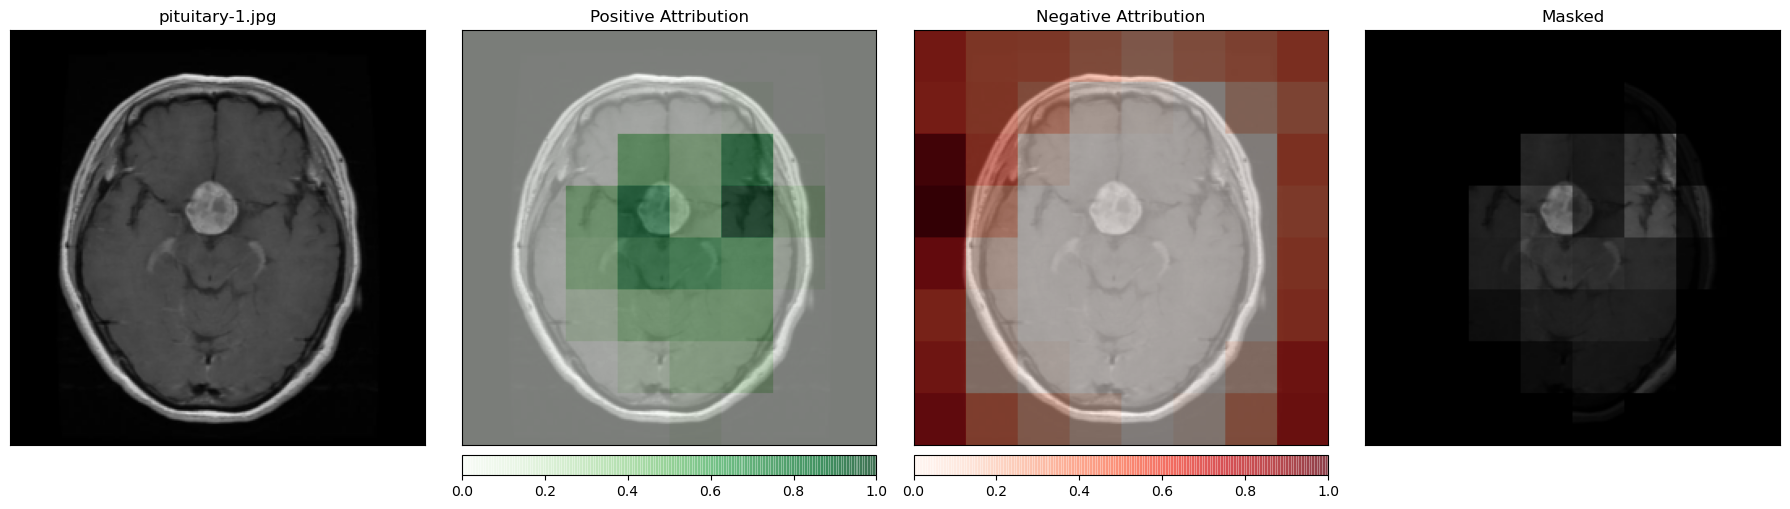

Predicted: pituitary_tumor (0.9996)


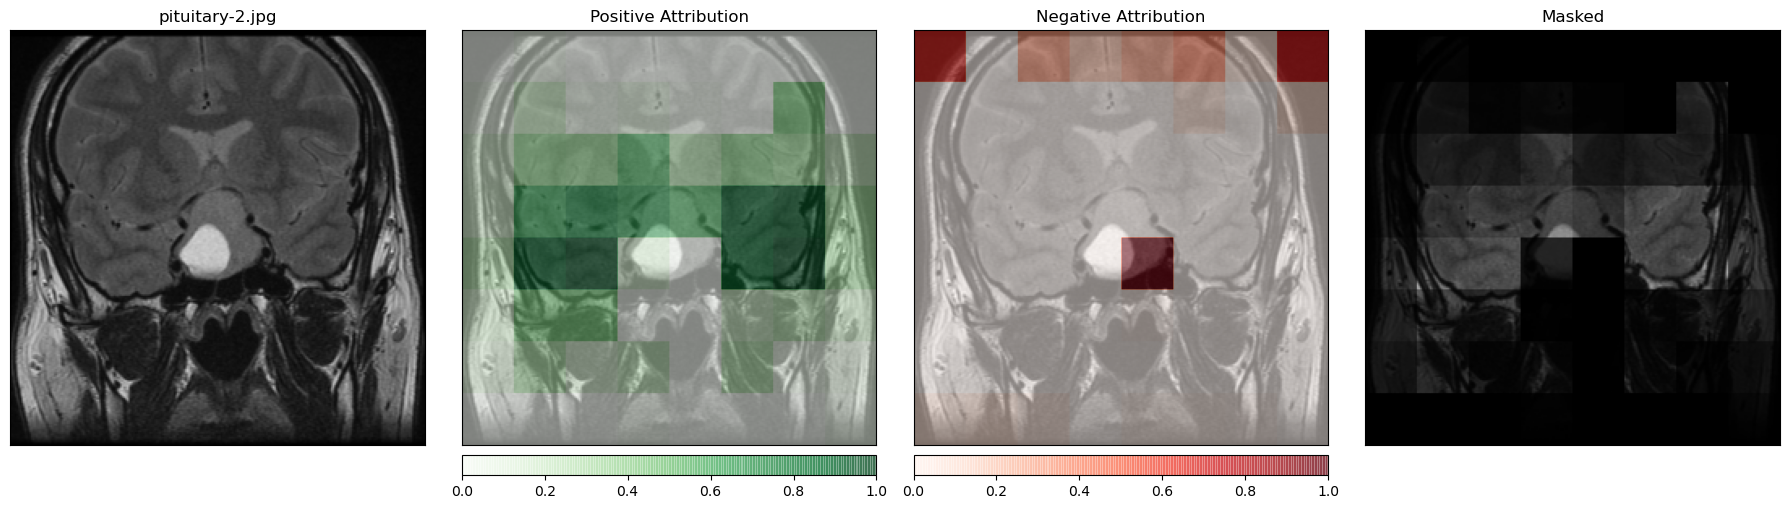

Predicted: pituitary_tumor (0.9998)


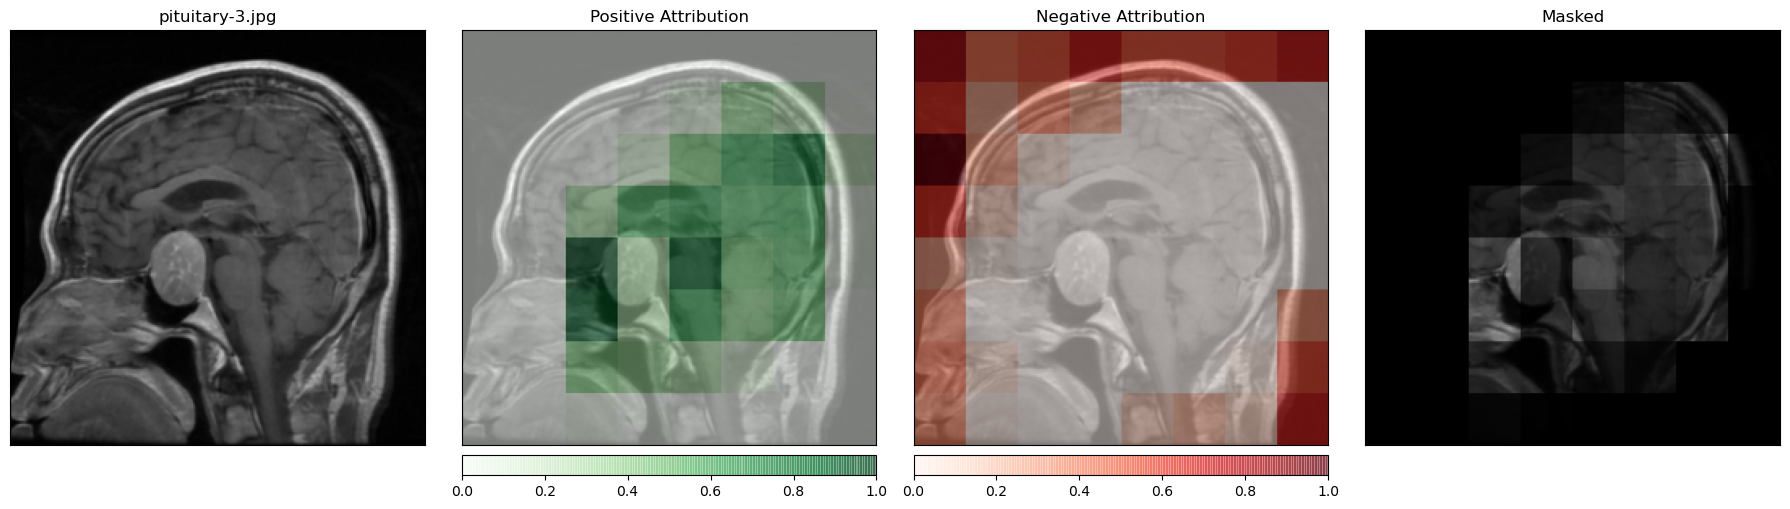

In [20]:
explain_folder = './explain-samples'

layer_gradcam = LayerGradCam(model, model.layer4[2].conv1)

img_ext =  ('png', 'jpg',  'tiff', 'bmp', 'gif')
images = [file for file in os.listdir(explain_folder) if file.lower().endswith(img_ext)]

for image_file in images:
    # preprocessing
    test_img = Image.open(os.path.join(explain_folder, image_file))
    transformed_img = transform(test_img)
    input_img = transform_normalize(transformed_img)
    input_img = input_img.unsqueeze(0) # the model requires a dummy batch dimension
        
    # get prediction
    pred_label_idx, pred_label = predict(input_img)

    # get layer attribution and upsample
    attributions_lgc = layer_gradcam.attribute(input_img, target=pred_label_idx)
    upsamp_attr_lgc = LayerAttribution.interpolate(attributions_lgc, input_img.shape[2:])

    # visualize results
    _ = viz.visualize_image_attr_multiple(upsamp_attr_lgc[0].cpu().permute(1,2,0).detach().numpy(),
                                      transformed_img.permute(1,2,0).numpy(),
                                      ["original_image","blended_heat_map","blended_heat_map", "masked_image"],
                                      ["all","positive","negative", "positive"],
                                      show_colorbar=True,
                                      titles=[image_file, "Positive Attribution", "Negative Attribution", "Masked"],
                                      fig_size=(18, 6))

# Register model in AML model repository

In [21]:
amlrun.upload_file('brain-tumor-classification.pth', model_path)

amlrun.register_model(model_name='brain-tumor-classification',
                   model_path='brain-tumor-classification.pth',
                   datasets = [('training', aml_dataset)],
                   model_framework=Model.Framework.PYTORCH,
                   model_framework_version=torch.__version__,
                   description='4-class brain tumor classification based on ResNet50',
                   tags={'area': 'healthcare', 'type': 'classification'}
                  )

record('Model registered in Azure ML')

23/01/2022 11:18 : Model registered in Azure ML


# End experiment and clean up

In [22]:
from mlflow import log_artifact
record('End of experiment run')
logtime = datetime.now().strftime("%d-%m-%Y-%H:%M")

try:
    mlflow.log_artifact('experiment.log')
except Exception as e: print(e)

mlflow.end_run()

23/01/2022 11:18 : End of experiment run
